In [169]:
savefig = False

## Notes:
- 20 has the best NSE
- opt 26 has improved the NSE to 0.363; however, the tail is fat, likely because of the gw model. Specifically, because gw2 ~1, all of the GW reservoir is released into the stream.
- opt 27 attempting an optimization with gw2 = 0
- opt 27 didn't work out that well, converged very quickly, but with an unrealistic hydrograph
- opt 28 - re-do opt 26 with a wider parameter space for gw1 and gw2
- opt 29 - re-do opt 28 with the snow parameters to improve timing
- opt 30 - calibration without gw2 and with all the other calibration parameters, soil depth was also increased to 50 m
- opt 31 - same as above, but soil depth is now also calibrated.
- opt 32 - add a loss term to the calibration...

### Sensitivity Anaylsis:

Using opt 26 to construct dotty plots, it appears that the objective function score is really only sensitive to gw1, gw2, and po

In [170]:
opt = '36'

In [171]:
from hydro import objective_fxns as obfx
import datetime

In [172]:
fl = './Como_SCEUA_%s.out'%opt

In [173]:
with open(fl) as f:
    dat = f.readlines()
    
dat = [x.strip() for x in dat] # remove whitespace

In [174]:
times = []
key = 'time cost'
for l in dat:
    if len(l) < len(key):
        exit
    
    if l[:len(key)] == key:
        tag,val = l.split('=')
        
    else:
        continue
    
    times.append(float(val.split(' ')[1]))

times = np.array(times)

In [175]:
times /= 60.

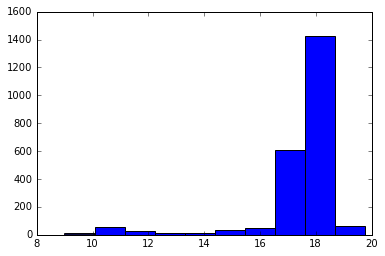

In [176]:
plt.hist(times);

In [177]:
len(times)

2306

In [178]:
tmp = pd.read_csv('./Como_SCEUA_%s.csv'%opt)

In [179]:
len(tmp)

1684

In [180]:
tmp.sort_values(by = 'like1',ascending=False).iloc[1:6,0:17]

,like1,pargw1,pargw2,parsd,parm,parksat,parcrd,partrd,parpo,parpa,parsnowtemp,parraintemp,parsmtc,parmsed,para,parb,parc
1331,-0.697543,0.366732,0.535613,28.837344,27.066846,174.014653,8.618792,3.765417,4.598476,872.177826,3.114270,-1.144304,0.483818,-90.209653,2.807890,8.273652,0.267717
170,-0.720584,0.146798,0.511612,33.457745,1.713607,42.207630,9.466007,0.186144,1.786236,195.209643,0.903864,-1.482395,0.429809,-53.448778,10.893611,11.568632,0.433467
322,-0.747122,0.166222,0.977398,12.711378,0.760063,157.973218,0.327006,2.091156,3.126341,10.755733,2.406260,-2.336071,0.290085,-89.739893,0.775249,9.181485,0.417465
287,-0.755793,0.377359,0.938620,24.928648,16.993713,412.459282,7.452124,0.731779,4.502328,148.401453,2.006044,-3.777153,0.038596,-80.953447,6.895170,9.567792,0.303473
1415,-0.759437,0.698929,0.433404,8.240478,6.020239,268.576340,7.567059,0.282721,4.571444,656.628695,2.568031,-0.989950,0.420797,-82.220105,9.235655,17.242156,0.543330


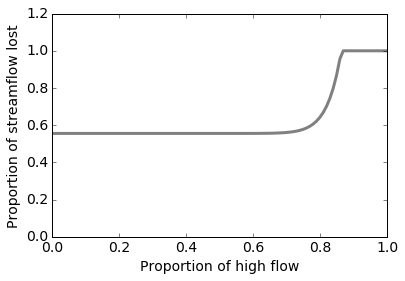

In [181]:
# define a function that increases the leakage as flow increases
def leakage(x,a,b,c): 
    y = a*(x**b) + c
    y[y>1.] = 1
    
    return y



x = np.linspace(0,1,100,endpoint=True)
y = leakage(x,10.204982,21.230562,0.555779)

plt.plot(x,y,'-',c='0.5',lw=3)
plt.xlabel('Proportion of high flow', fontsize = 14)
plt.ylabel('Proportion of streamflow lost',fontsize = 14)
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
plt.ylim(0,1.2)
if savefig: plt.savefig('./figures/optimized_leakage_curve.png',bbox_inches='tight',dpi=300)
if savefig: plt.savefig('./figures/optimized_leakage_curve.pdf',bbox_inches='tight')

In [182]:
obs = pd.read_pickle('/RHESSys/Como/obs/como_q_obs.pcl')['2004-10-01':'2007-09-30']
obs = obs.discharge.as_matrix()

In [183]:
nses = []
for i in np.arange(0,len(tmp)):
    simtmp = tmp.iloc[i,17:-1].as_matrix()
    nses.append(obfx.nashsut(obs,simtmp))

In [184]:
round(np.max(nses),2)

0.73

In [185]:
round(np.min(nses),2)

-10.77

In [186]:
sim = tmp.sort_values(by = 'like1',ascending=False).iloc[1,17:-1].as_matrix()
#print len(obs)
#print len(sim)
#4
#9

In [187]:
nse = obfx.nashsut(obs,sim)
print 'NSE: %s'%round(nse,3)

NSE: 0.731


In [188]:
tmp.sort_values(by = 'like1',ascending=False,inplace=True)

In [189]:
# fill a data frame with the top twenty
sims = pd.DataFrame()
for i in range(20):
    sims['sim_%i'%i] = tmp.iloc[i,17:-1].as_matrix()

sims.index = pd.DatetimeIndex(pd.date_range(start='2004-10-01',periods=len(sim),freq='D'))
sims['idx'] = np.arange(0,len(sims))

In [190]:
sims = pd.melt(sims,id_vars='idx')

In [191]:
dat = pd.DataFrame()
dat['Observations'] = obs
dat['Simulation'] = sim
dat['Sim_min'] = sims.groupby(by='idx').min()['value']
dat['Sim_max'] = sims.groupby(by='idx').max()['value']
dat.index = pd.DatetimeIndex(pd.date_range(start='2004-10-01',periods=len(sim),freq='D'))

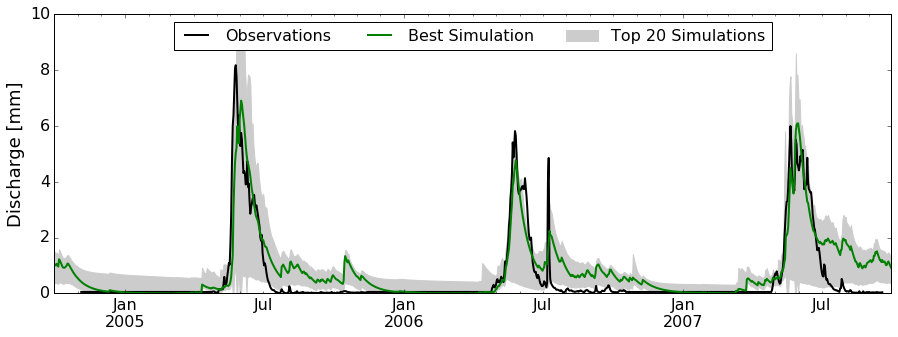

In [192]:
#plt.figure(figsize=(15,5))
dat['Observations'].plot(figsize=(15,5),color='k',lw=2,label='Observations')
dat['Simulation'].plot(figsize=(15,5),color='g',lw=2,label='Best Simulation')
plt.fill_between(dat.index,dat.Sim_min,dat.Sim_max,facecolor='0.8',edgecolor='0.8',zorder=1,color='0.8',label='Top 20 Simulations')
plt.ylim(0,10)
plt.legend(fontsize=16,ncol=3,loc='upper center')
plt.ylabel('Discharge [mm]', fontsize = 18)
ax = plt.gca()
#plt.title('Como Creek, Training Period NSE: %s'%(round(nse,3)), fontsize = 20)
[tick.label.set_fontsize(16) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(16) for tick in ax.xaxis.get_minor_ticks()];
[tick.label.set_fontsize(16) for tick in ax.yaxis.get_major_ticks()];
if savefig: plt.savefig('./figures/experiment_calibration_%s.png'%(opt),dpi=300,bbox_inches='tight')

## Sensitivity Dotty Plots - from Opt. 26

In [346]:
def dotty_plot(par,label):
    labelsize = 16
    tmp.plot.scatter('like1',par,figsize=(10,5))
    plt.ylabel(label, fontsize=labelsize)
    plt.xlabel('Likelihood', fontsize=labelsize)
    ax = plt.gca()
    [tick.label.set_fontsize(labelsize-2) for tick in ax.xaxis.get_major_ticks()];
    [tick.label.set_fontsize(labelsize-2) for tick in ax.yaxis.get_major_ticks()];
    plt.xlim(-2,-1)

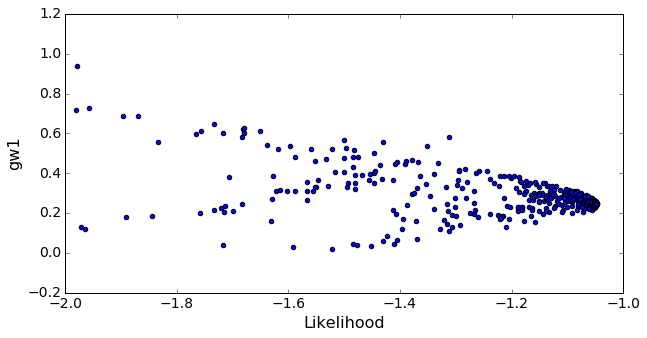

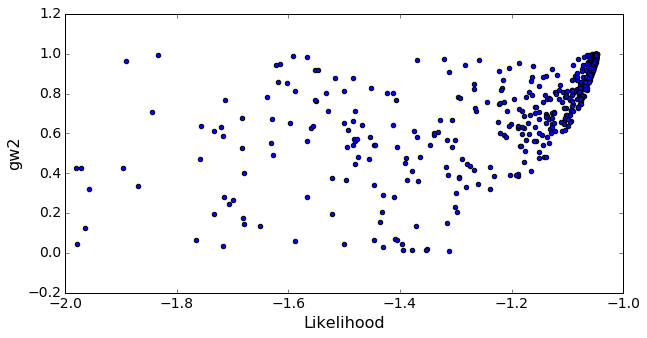

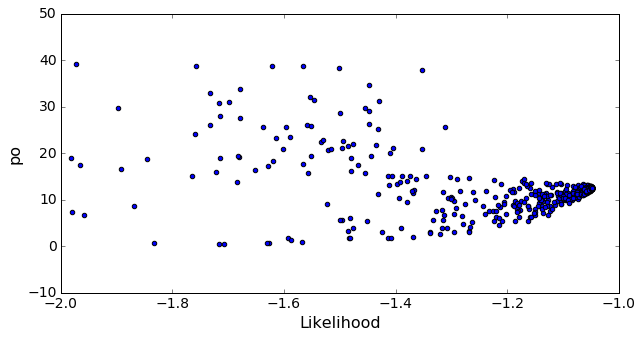

In [347]:
dotty_plot('pargw1','gw1')
dotty_plot('pargw2','gw2')
dotty_plot('parpo','po')

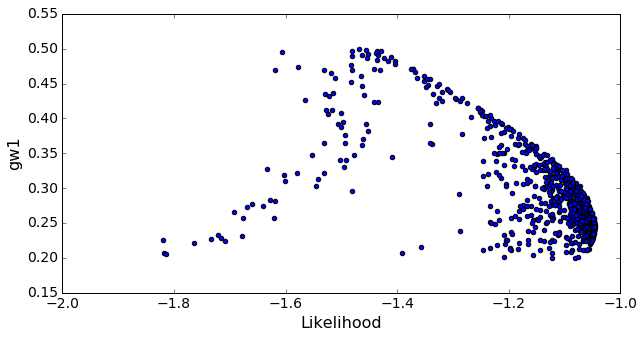

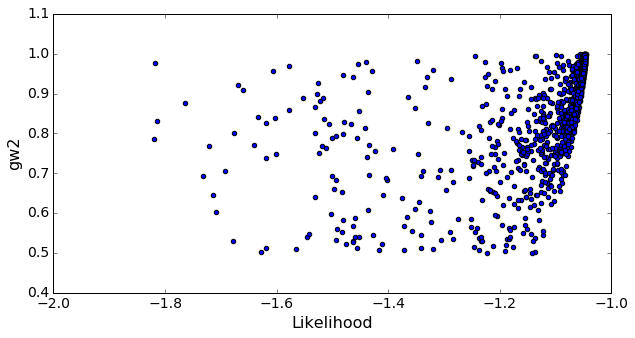

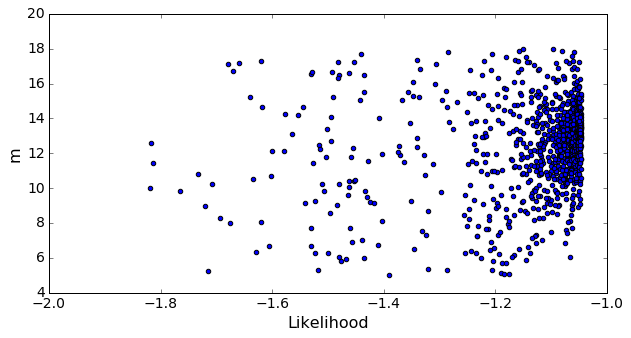

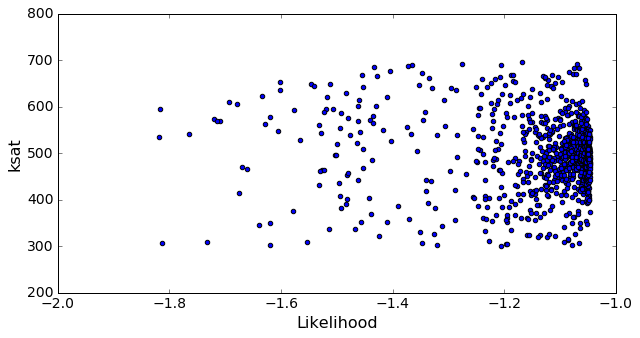

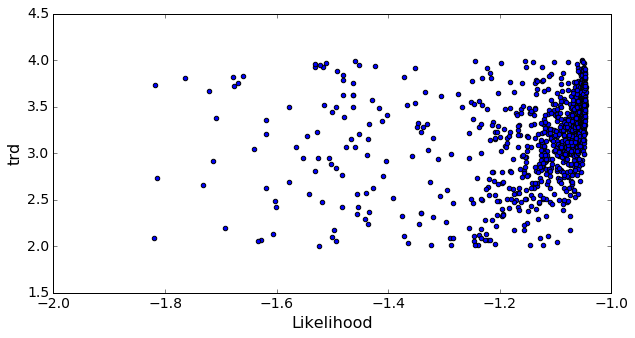

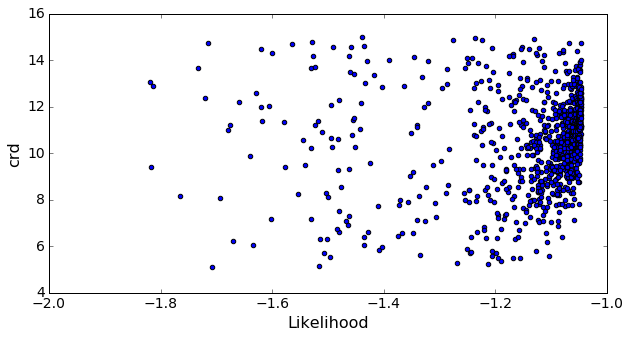

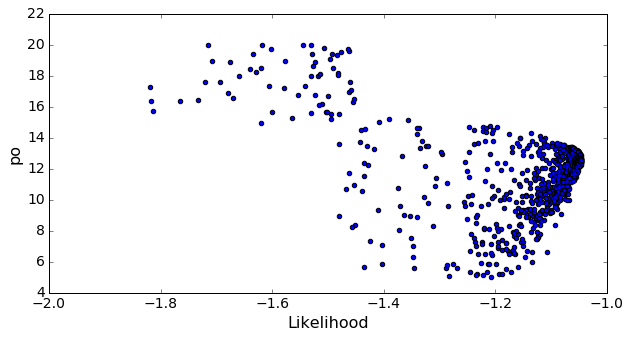

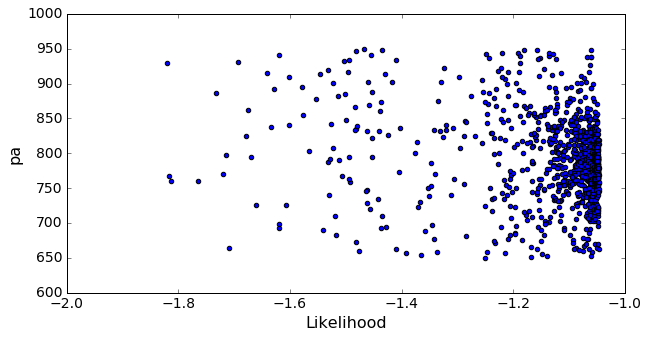

In [300]:
dotty_plot('pargw1','gw1')
dotty_plot('pargw2','gw2')
dotty_plot('parm','m')
dotty_plot('parksat','ksat')
dotty_plot('partrd','trd')
dotty_plot('parcrd','crd')
dotty_plot('parpo','po')
dotty_plot('parpa','pa')

(-2, -1)

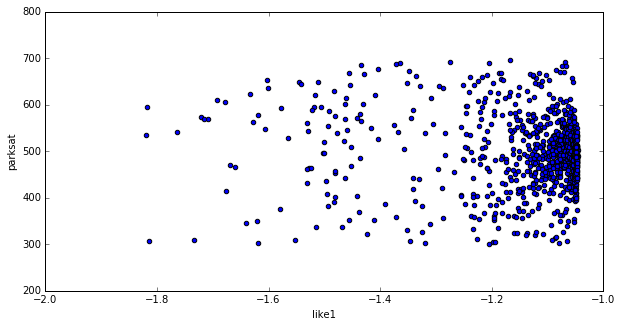

In [173]:
tmp.plot.scatter('like1','parksat',figsize=(10,5))
plt.xlim(-2,-1)

(-2, -1)

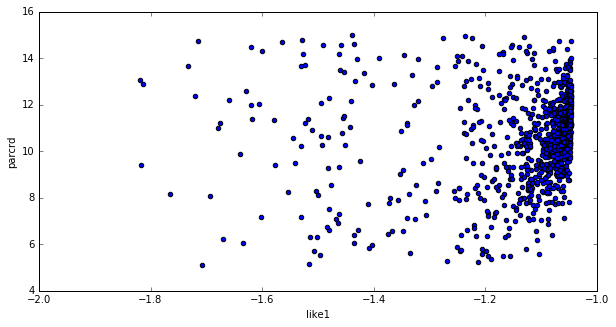

In [174]:
tmp.plot.scatter('like1','parcrd',figsize=(10,5))
plt.xlim(-2,-1)

(-2, -1)

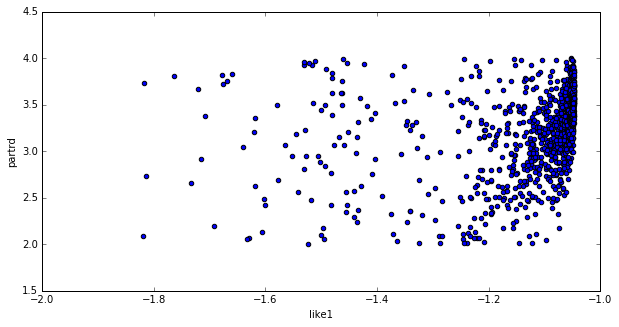

In [175]:
tmp.plot.scatter('like1','partrd',figsize=(10,5))
plt.xlim(-2,-1)

(-2, -1)

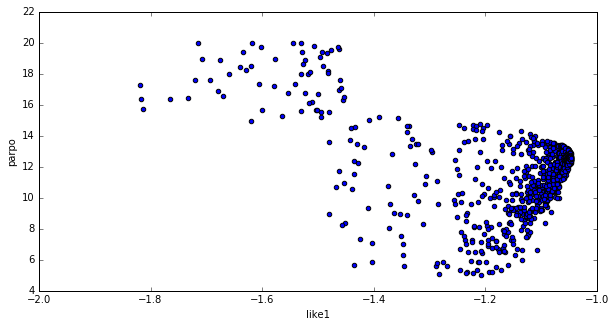

In [176]:
tmp.plot.scatter('like1','parpo',figsize=(10,5))
plt.xlim(-2,-1)

(-2, -1)

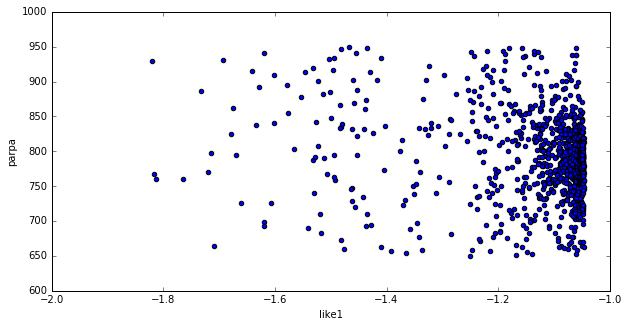

In [177]:
tmp.plot.scatter('like1','parpa',figsize=(10,5))
plt.xlim(-2,-1)